Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one seven­day period , identify which factors predict future user
adoption .


Please send us a brief writeup of your findings (the more concise, the better ­­ no more
than one page), along with any summary tables, graphs, code, or queries that can help
us understand your approach.


Please note any factors you considered or investigation
you did, even if they did not pan out. Feel free to identify any further research or data
you think would be valuable.

## Imports

In [332]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn import __version__ as sklearn_version
from scipy.stats import randint

## Read Data

In [333]:
rawdata = open("./takehome_users.csv", "rb").read()
result = chardet.detect(rawdata)
df1 = pd.read_csv('./takehome_users.csv',encoding=result["encoding"])
df2 = pd.read_csv('./takehome_user_engagement.csv')

In [334]:
df1.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [335]:
# Wrangle first dataframe
df1['last_session_creation_time'] = pd.to_datetime(df1['last_session_creation_time'], unit='s', utc=True)
df1['creation_time'] = pd.to_datetime(df1['creation_time'])
df1.rename({'object_id':'user_id'}, axis=1, inplace=True)
df1 = pd.get_dummies(df1, columns=['creation_source'], drop_first=True)

In [336]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype              
---  ------                              --------------  -----              
 0   user_id                             12000 non-null  int64              
 1   creation_time                       12000 non-null  datetime64[ns]     
 2   name                                12000 non-null  object             
 3   email                               12000 non-null  object             
 4   last_session_creation_time          8823 non-null   datetime64[ns, UTC]
 5   opted_in_to_mailing_list            12000 non-null  int64              
 6   enabled_for_marketing_drip          12000 non-null  int64              
 7   org_id                              12000 non-null  int64              
 8   invited_by_user_id                  6417 non-null   float64            
 9   creation_source_ORG_INVITE          120

In [337]:
# Wrangle second dataframe
df2['time_stamp'] = pd.to_datetime(df2['time_stamp'])
df2['date'] = df2['time_stamp'].dt.date
df2 = df2.drop_duplicates(subset=['user_id', 'date'], keep='first')
df2.drop(columns=['time_stamp', 'visited'], axis=1, inplace=True)
df2.sort_values(['user_id', 'date'], inplace=True)
df2.head()

,user_id,date
0,1,2014-04-22
1,2,2013-11-15
2,2,2013-11-29
3,2,2013-12-09
4,2,2013-12-25


In [338]:
# Find which users have visited 3 times in a 7 day time frame
user_list = set(df2['user_id'])
df_a = pd.DataFrame(columns=['user_id', 'adoption'])
for user in user_list:
    data = list(df2[df2['user_id'] == user]['date'])
    df_a = pd.concat([df_a, pd.DataFrame({'user_id': [user], 'adoption': [0]})], ignore_index=True)
    n = len(data)
    df_a.head()
    for i in range(2,n,1):
        if (data[i] - data[i-2]).days <= 7:
            df_a.loc[df_a['user_id'] == user, ['adoption']] = 1
            break
df_a.head(5)
df_a['adoption'] = df_a['adoption'].apply(int)

In [339]:
# Merge
df = df1.merge(df_a, how='left', on='user_id')
df.head()

,user_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,adoption
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,2014-04-22 03:53:30+00:00,1,0,11,10803.0,False,False,False,False,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,2014-03-31 03:45:04+00:00,0,0,1,316.0,True,False,False,False,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,2013-03-19 23:14:52+00:00,0,0,94,1525.0,True,False,False,False,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,2013-05-22 08:09:28+00:00,0,0,1,5151.0,False,False,False,False,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,2013-01-22 10:14:20+00:00,0,0,193,5240.0,False,False,False,False,0.0


In [340]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 14 columns):
 #   Column                              Non-Null Count  Dtype              
---  ------                              --------------  -----              
 0   user_id                             12000 non-null  object             
 1   creation_time                       12000 non-null  datetime64[ns]     
 2   name                                12000 non-null  object             
 3   email                               12000 non-null  object             
 4   last_session_creation_time          8823 non-null   datetime64[ns, UTC]
 5   opted_in_to_mailing_list            12000 non-null  int64              
 6   enabled_for_marketing_drip          12000 non-null  int64              
 7   org_id                              12000 non-null  int64              
 8   invited_by_user_id                  6417 non-null   float64            
 9   creation_source_ORG_INVITE          120

In [341]:
# Drop and wrangle useless features
df['adoption'] = df['adoption'].fillna(0)
df['invited'] = 1
df.loc[df['invited_by_user_id'].isna(), 'invited'] = 0
df.drop(['user_id', 'creation_time', 'name', 'email', 
         'last_session_creation_time', 'org_id', 'invited_by_user_id'], axis=1, inplace=True)

In [342]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   opted_in_to_mailing_list            12000 non-null  int64  
 1   enabled_for_marketing_drip          12000 non-null  int64  
 2   creation_source_ORG_INVITE          12000 non-null  bool   
 3   creation_source_PERSONAL_PROJECTS   12000 non-null  bool   
 4   creation_source_SIGNUP              12000 non-null  bool   
 5   creation_source_SIGNUP_GOOGLE_AUTH  12000 non-null  bool   
 6   adoption                            12000 non-null  float64
 7   invited                             12000 non-null  int64  
dtypes: bool(4), float64(1), int64(3)
memory usage: 422.0 KB


## Modeling

### Train/Test Split

In [343]:
# Split data into train and test splits
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='adoption'), 
                                                    df.adoption,
                                                    test_size=0.3,
                                                    random_state=67)

### Random Forest

In [344]:
# Random forest pipeline
rf_model = RandomForestClassifier(random_state=47)

In [345]:
# Fit to trianing data
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=47)

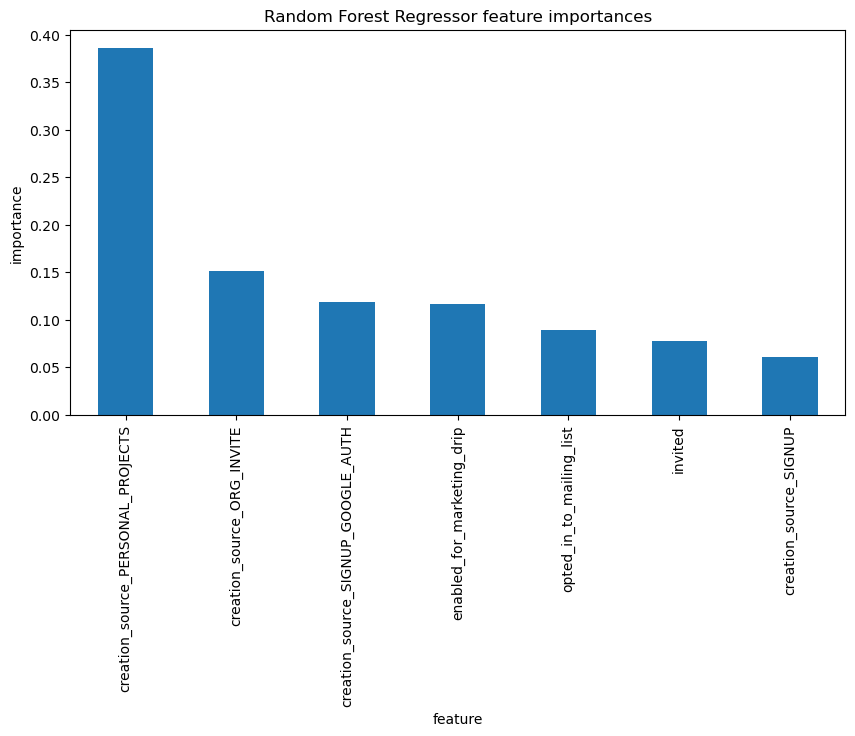

In [346]:
# See what features the Random Forest model deems most important
plt.subplots(figsize=(10, 5))
imps = rf_model.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('feature')
plt.ylabel('importance')
plt.title('Random Forest Regressor feature importances');

These are the features the model deems "most important" to predicting user adoption.